In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import cv2

# Toggle between grayscale and RGB input
use_rgb = True
image_size = (64, 64)
input_channels = 3 if use_rgb else 1
input_size = image_size[0] * image_size[1] * input_channels

# Load images and labels
def load_images_from_folder(folder, label, use_rgb):
    images = []
    labels = []
    for filename in os.listdir(folder):
        flag = cv2.IMREAD_COLOR if use_rgb else cv2.IMREAD_GRAYSCALE
        img = cv2.imread(os.path.join(folder, filename), flag)
        if img is not None:
            img = cv2.resize(img, image_size)
            if not use_rgb:
                img = np.expand_dims(img, axis=-1)
            images.append(img / 255.0)
            labels.append(label)
    return images, labels

pleasant_images, pleasant_labels = load_images_from_folder('train-images/train/pleasant', 1, use_rgb)
unpleasant_images, unpleasant_labels = load_images_from_folder('train-images/train/unpleasant', 0, use_rgb)

X = np.array(pleasant_images + unpleasant_images, dtype=np.float32)
y = np.array(pleasant_labels + unpleasant_labels, dtype=np.int64)

In [2]:
# Convert to CHW format for PyTorch
X = X.transpose((0, 3, 1, 2)) if use_rgb else X.transpose((0, 1, 2))[:, np.newaxis, :, :]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [3]:
# Define CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layers
        # instance with 3 layers
        '''self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout(0.25)'''
        # instance with 4 layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout(0.25)
        # dense layers
        # instance with 3 convolutional 2 dense layers
        '''self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)'''
        # instance with 3 convolutional 1 dense layer
        '''self.fc = nn.Linear(128 * 8 * 8, 2)'''
        # instance with 4 convolutional 2 dense layers
        self.fc1 = nn.Linear(256 * 4 * 4, 128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)
        # instance with 4 convolutional 1 dense layer
        '''self.fc = nn.Linear(256 * 4 * 4, 2) '''
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # convolutional layers
        # instance with 3 layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # instance with 4th layer
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout_conv(x)
        x = x.reshape(x.size(0), -1)
        # dense layers
        # instance with 2 layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        # instance with 1 layer
        '''x = self.fc(x)'''
        
        return self.softmax(x)
        

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

Epoch 1/15, Loss: 0.5150
Epoch 2/15, Loss: 0.4483
Epoch 3/15, Loss: 0.4251
Epoch 4/15, Loss: 0.4000
Epoch 5/15, Loss: 0.3897
Epoch 6/15, Loss: 0.3743
Epoch 7/15, Loss: 0.3616
Epoch 8/15, Loss: 0.3537
Epoch 9/15, Loss: 0.3487
Epoch 10/15, Loss: 0.3437
Epoch 11/15, Loss: 0.3390
Epoch 12/15, Loss: 0.3339
Epoch 13/15, Loss: 0.3319
Epoch 14/15, Loss: 0.3314
Epoch 15/15, Loss: 0.3308
Accuracy: 0.9278996865203761
Precision: 0.9239598278335724
Recall: 0.9428989751098097
F1 Score: 0.9333333333333333
Confusion Matrix:
 [[540  53]
 [ 39 644]]


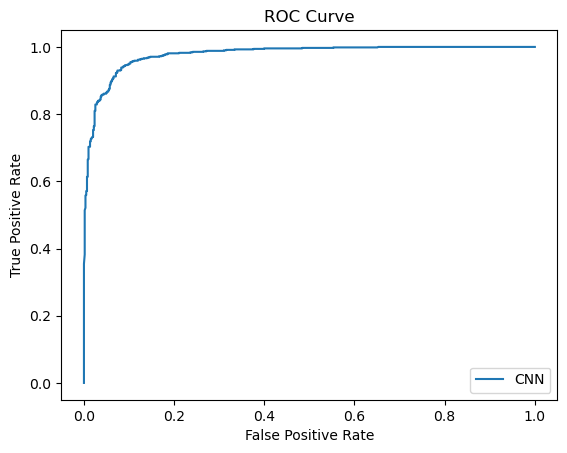

In [4]:
# Training loop
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()            # reset gradients
        outputs = model(batch_x)         # forward pass
        loss = criterion(outputs, batch_y) # compute loss
        loss.backward()                  # backpropagate
        optimizer.step()                 # update weights
        total_loss += loss.item()        # accumulate
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
y_preds, y_trues, y_scores = [], [], []
with torch.no_grad():
    for batch_x, batch_y in val_loader:
        outputs = model(batch_x)
        _, preds = torch.max(outputs, 1)
        y_preds.extend(preds.tolist())
        y_trues.extend(batch_y.tolist())
        y_scores.extend(F.softmax(outputs, dim=1)[:, 1].tolist())

print("Accuracy:", accuracy_score(y_trues, y_preds))
print("Precision:", precision_score(y_trues, y_preds))
print("Recall:", recall_score(y_trues, y_preds))
print("F1 Score:", f1_score(y_trues, y_preds))
print("Confusion Matrix:\n", confusion_matrix(y_trues, y_preds))

fpr, tpr, _ = roc_curve(y_trues, y_scores)
plt.plot(fpr, tpr, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [5]:
# Predict test set
test_df = pd.read_csv('Test-IDs.csv')
submission = []

model.eval()
for _, row in test_df.iterrows():
    img_path = os.path.join('TEST_images/TEST_images', row['Filename'])
    flag = cv2.IMREAD_COLOR if use_rgb else cv2.IMREAD_GRAYSCALE
    img = cv2.imread(img_path, flag)
    if img is not None:
        img = cv2.resize(img, image_size)
        if not use_rgb:
            img = np.expand_dims(img, axis=-1)
        img = img.transpose((2, 0, 1)) if use_rgb else img.transpose((2, 0, 1))
        img = img[np.newaxis, ...] / 255.0
        img_tensor = torch.tensor(img, dtype=torch.float32).contiguous()
        output = model(img_tensor)
        _, pred = torch.max(output, 1)
        submission.append({'ID': row['ID'], 'LABEL': int(pred.item())})

submission_df = pd.DataFrame(submission)
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved with CNN predictions.")

Submission file saved with CNN predictions.
